# Prj_GAN (Generative AI)

Task discription: You have been given a simulated dataset and a pre-trained generative model (see readme.txt).

- The training data is in `images.csv` and `coords.csv`.
- The generative model is in `WGAN.model`.

- Your first task is to use the pre-trained model to generate a new image.
- Your second task is to re-train your own WGAN model using a suitable optimization strategy. For the second task, describe statistics for benchmarking your generative model.


## Task 1: Inference using pre-trained model


### preparing data and model


- import libs as needed
- peek folder structure, make sure not null
- read data from cache, if available


In [1]:
# model utils
from generative_model import WGAN_SIMPLE, eval_model
from process_data import load_csv_with_cache, MinMaxScaler
from plotting import plot_mean_std, plot_distribution

# paths
from glob import glob

# computation
import numpy as np
import pandas as pd
import torch

# graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_ROOT = '../DATA'
MODEL_ROOT = '../MODEL'
data_paths, model_paths = glob(f'{DATA_ROOT}/*'), glob(f'{MODEL_ROOT}/*')
print(f'data paths: {data_paths}\n'
      f'model paths: {model_paths}')

data paths: ['../DATA/Rayleigh_P30_downsampled_flat.csv', '../DATA/downsampled_points.csv', '../DATA/downsampled_points.csv.pkl', '../DATA/Rayleigh_P30_downsampled_flat.csv.pkl']
model paths: ['../MODEL/WGAN_uniform_lr2e-4_0.9_b128', '../MODEL/WGAN_Simple_epoch199.model', '../MODEL/WGAN_lr2e-4_0.5_b128', '../MODEL/WGAN_lr2e-4_0.9_b128']


In [3]:
data = load_csv_with_cache(f'{DATA_ROOT}/Rayleigh_P30_downsampled_flat.csv')
cord = load_csv_with_cache(f'{DATA_ROOT}/downsampled_points.csv')
avg = np.mean(data, axis=0)

scaler = MinMaxScaler()
scaler.fit(data)

normed_data = scaler.transform(data)
n_features = normed_data.shape[1]

### model inference


- load model (in a bit hacky way)
- infer a new distribution


In [4]:
model = WGAN_SIMPLE(nhid=200)
checkpoint = torch.load(f'{MODEL_ROOT}/WGAN_SIMPLE_epoch199.model')
model.load_state_dict({
    k.replace("model.", ""): v
    for k, v in checkpoint["model_state_dict"].items()
})

<All keys matched successfully>

In [5]:
with torch.no_grad():
    model.eval()
    fake_data = model.generate(normed=True)

### plotting results


- plot mean/std heatmap
- get mean, std, w-distance as a metric
- see how `diff=real-fake` is distributed


mean: 0.23239138859887967, std: 0.19948665146018058, emd: 0.29337238365718965


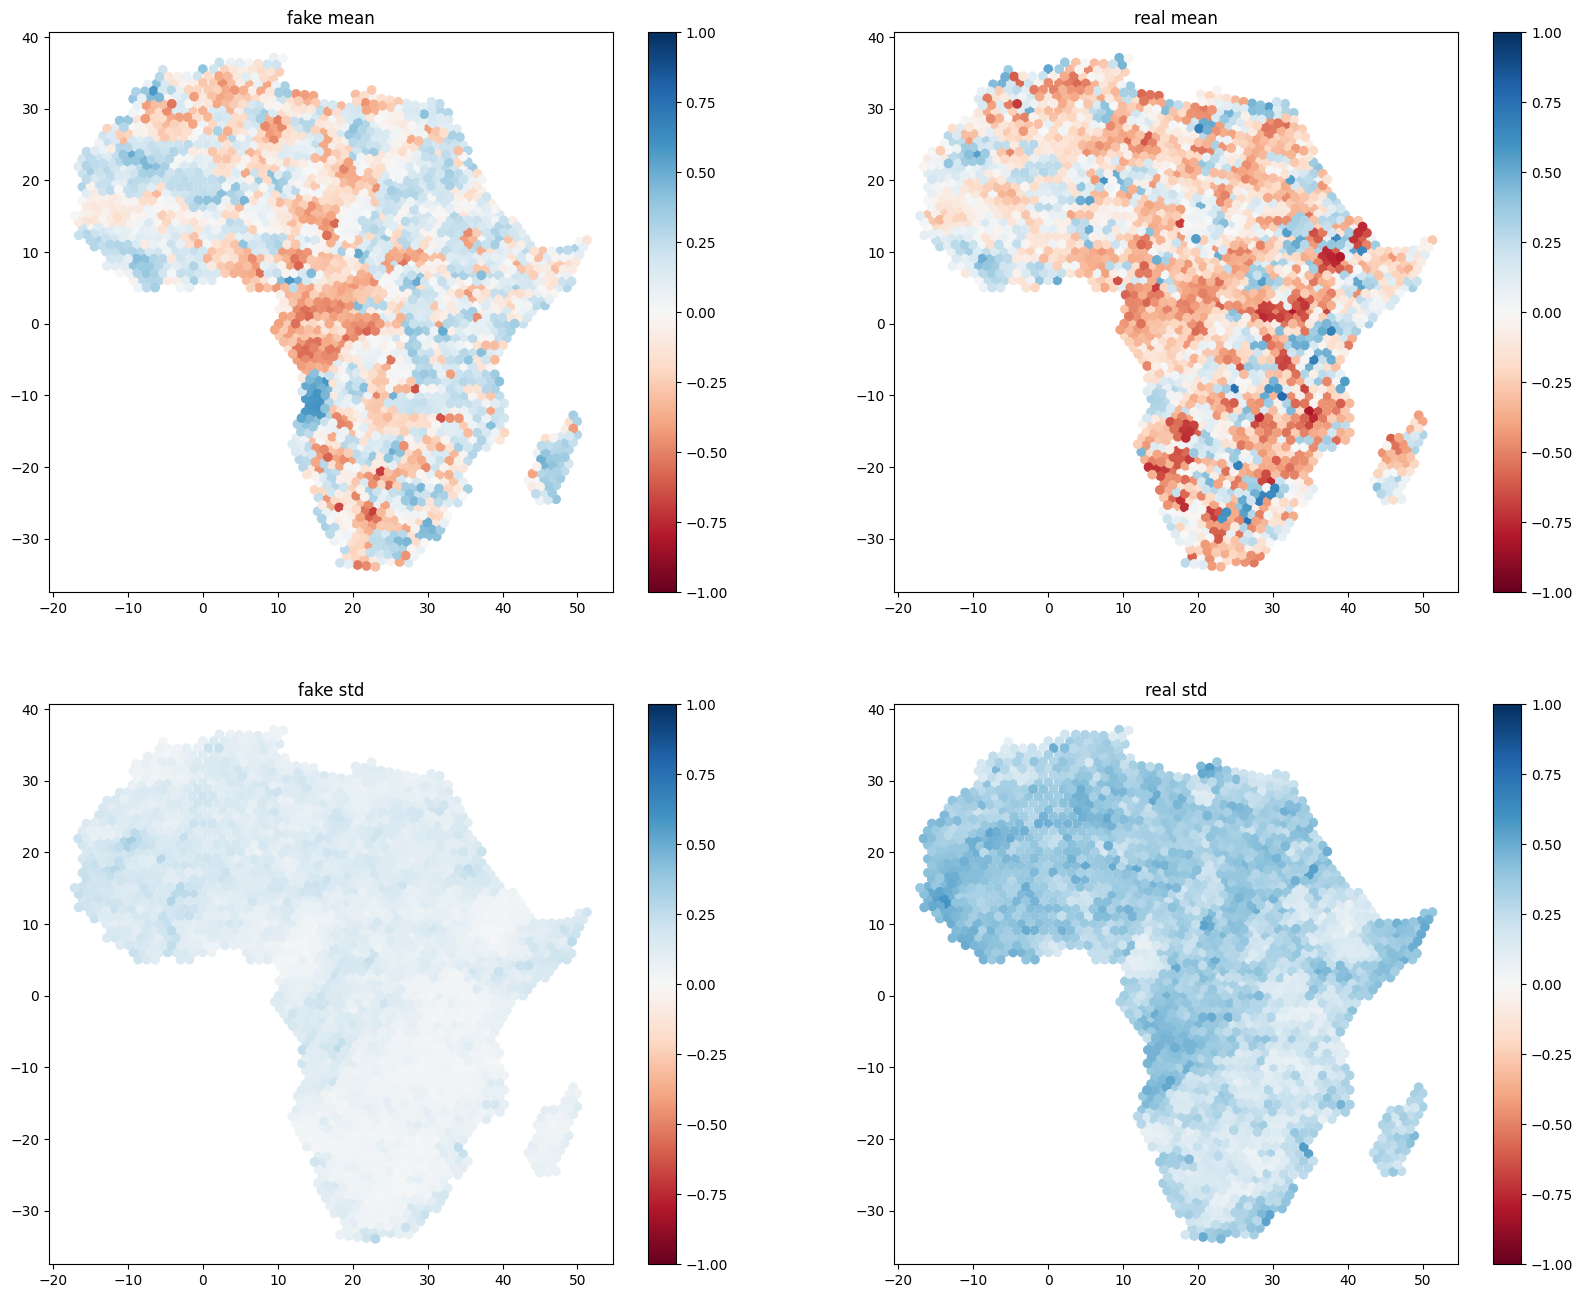

In [6]:
plot_mean_std(fake_data, normed_data, cord)
mean, std, emd = eval_model(model, normed_data, normed=True)
print(f'mean: {mean}, std: {std}, emd: {emd}')

### visualize distribution


- plot a histogram on the first feature; compare how fake data is distributed compared to real data.
- see how discriminator behaves; turns out our discriminator is bad, it cannot distinguish noise/fake/real.

it is obvious that the real data is not a gaussian but **mixture of gaussians**, making it hard to generate a good model.
the given model is trying to capture it as a mixture of several gaussians, but the distribution is not as good.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


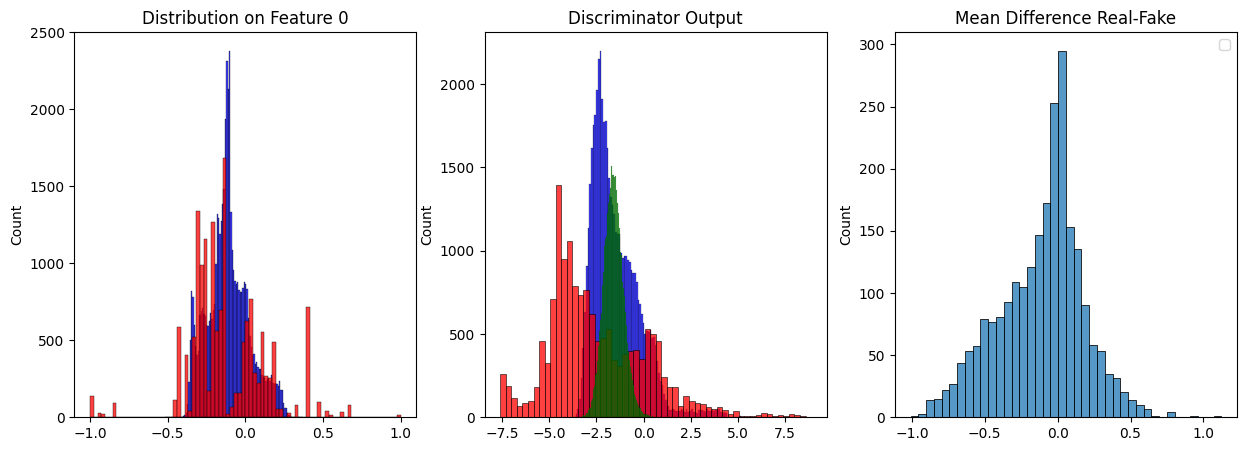

In [7]:
plot_distribution(
    torch.Tensor(fake_data),
    torch.Tensor(normed_data),
    torch.randn(50000, 2382),
    model
)

## Task 2: Training our own WGAN model


- training script is in a seperate file, see `train.py`
- we notice that given model is trying to map std gaussian $Z$ to real data which actually converges slowly and badly. we are trying to address this issue by map a uniform $U(-1,1)$ to real data.


In [8]:
model = torch.load(
    f'{MODEL_ROOT}/WGAN_uniform_lr2e-4_0.9_b128/199.pt', map_location='cpu')
model.device = 'cpu'

mean: 0.01261746404666709, std: 0.15111710632799497, emd: 0.11300747974673746


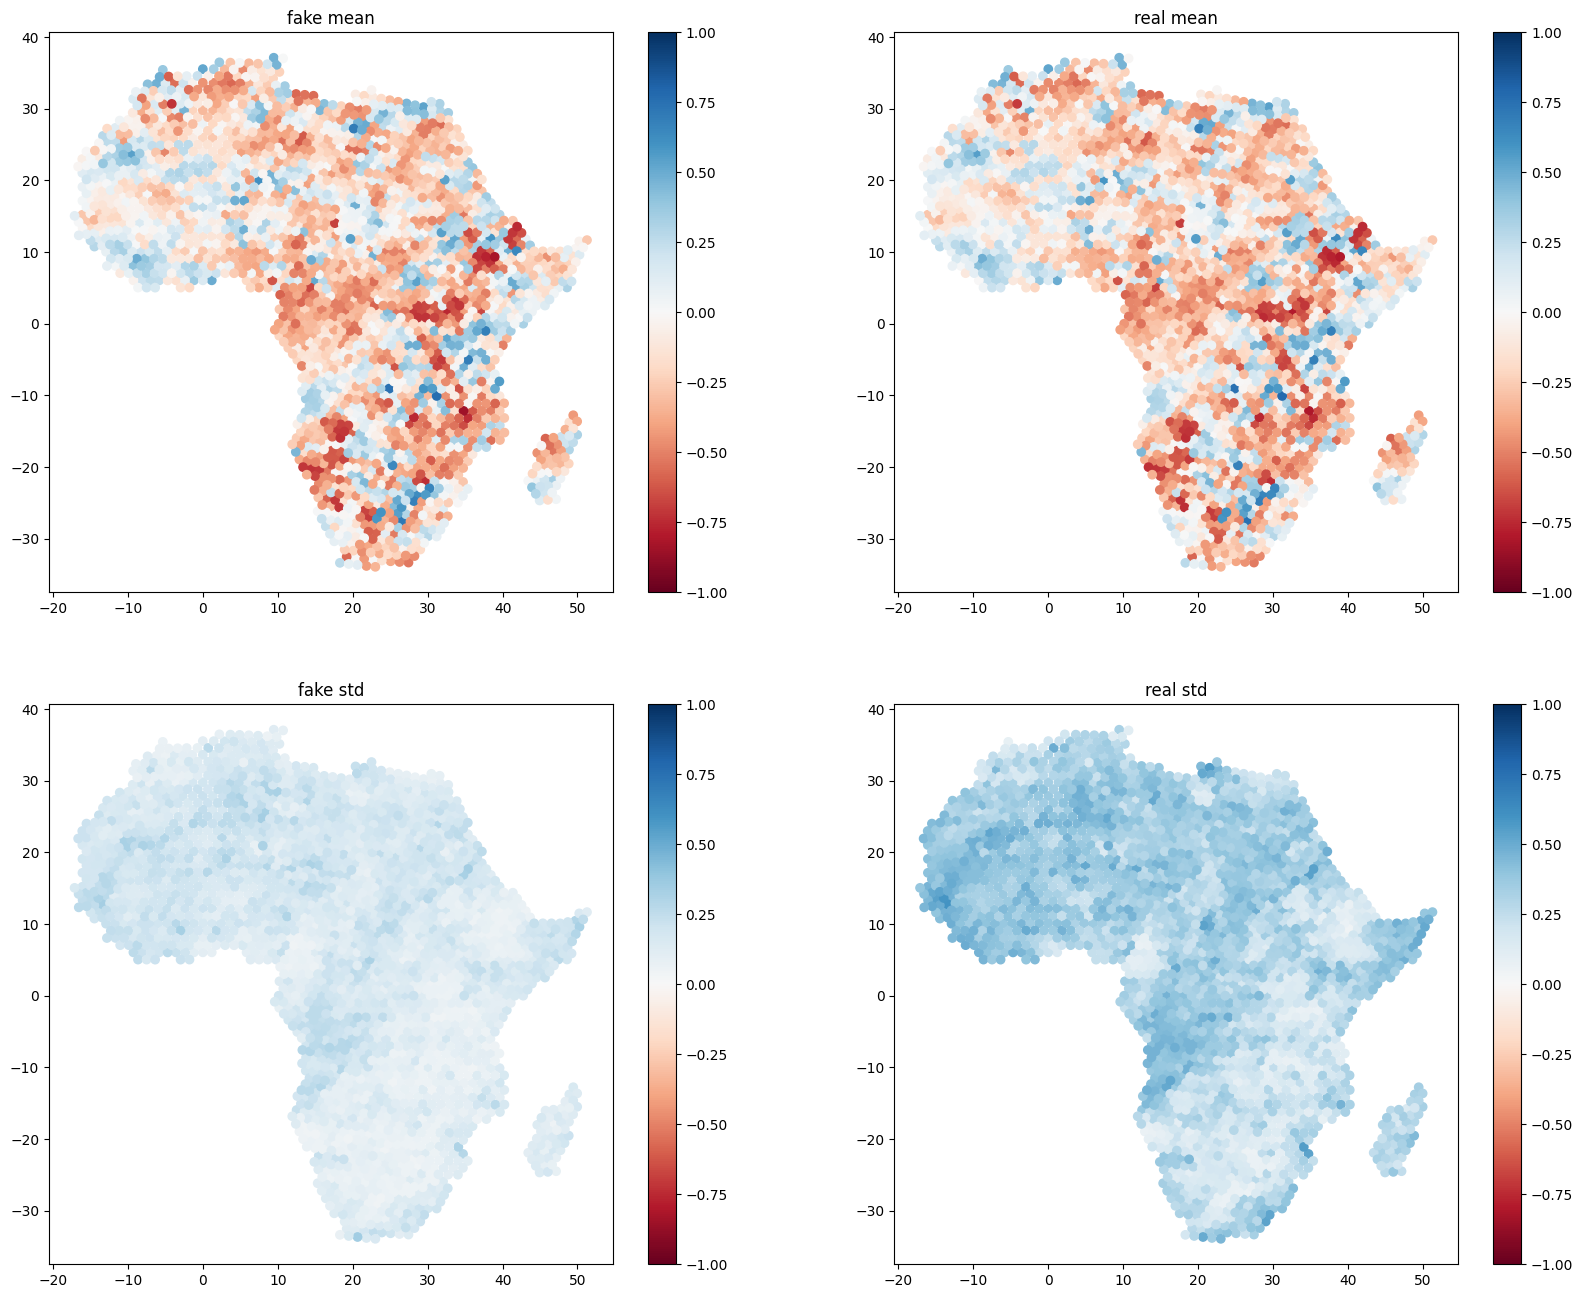

In [9]:
with torch.no_grad():
    model.eval()
    new_fake_data = model.generate()

plot_mean_std(new_fake_data, normed_data, cord)
mean, std, emd = eval_model(model, normed_data, normed=False)
print(f'mean: {mean}, std: {std}, emd: {emd}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


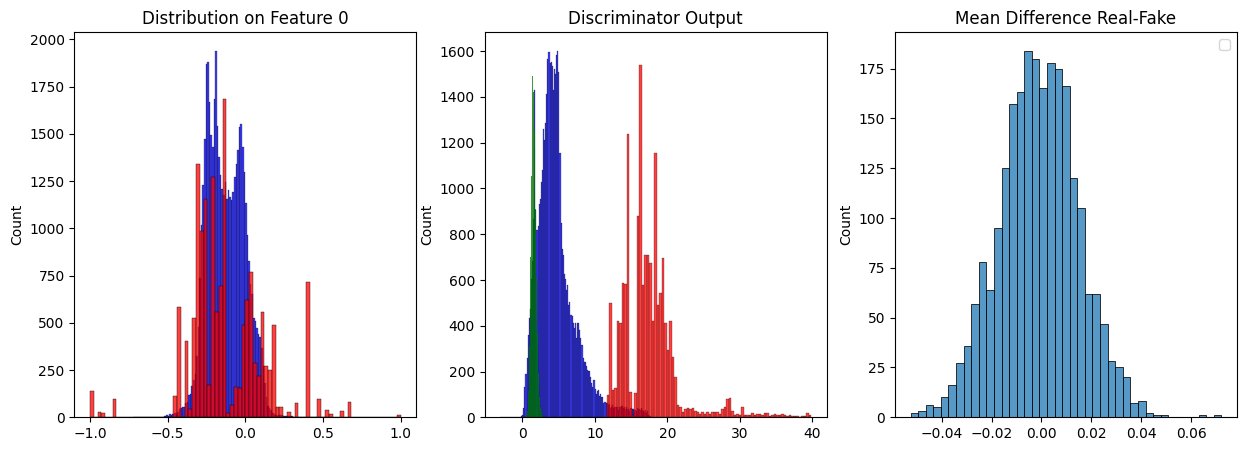

In [10]:
plot_distribution(
    torch.Tensor(new_fake_data),
    torch.Tensor(normed_data),
    model.sample_z(50000, 2382),
    model
)